In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

### Using an NN to solve a simple PDE

Goal is to construct an NN which can approximate solutions to the following PDE:

\begin{aligned}
    \nabla u &= f(x, y) \\
    f(x,y) &= 13\pi^2\sin(2\pi x)\sin(3\pi x) \\
    u &= 0 \text{   on   } \partial\Omega \text{   if   } a=c=0, b=d=1
\end{aligned}

The loss function should be of the form:

$$ \mathcal{L} = \sum_{i \epsilon \Omega} (-\nabla \hat{u}(x_i, y_i) - f(x_i, y_i))^2 + \gamma \sum_{i \epsilon \partial \bar{\Omega}}(\hat{u}(x_i, y_i))^2$$




In [28]:
class PDE_nn(nn.Module):
    """Construct a class that allows flexible control over the number of layers and number
       of units per layer"""
    def __init__(self, layers=[2, 20, 20, 20, 1]):
        
        super().__init__() # So nn.Module methods are accessible directly

        # Construct nn architecture from layers input
        self.linears = nn.ModuleList()
        for i in range(len(layers) -1):
            in_size = layers[i]
            out_size = layers[i+1]
            self.linears.append(nn.Linear(in_size, out_size))

        # I'm gonna use tanh activation functions. xavier initialisation on the weights
        # is good for that
        for j in self.linears:
            nn.init.xavier_normal_(j.weight)
            nn.init.zeros_(j.bias)
    
    def forward(self, x, y):
        # Combine x, y points into single tensor of shape [N, 2]
        input_ = torch.stack((x, y), dim=1)

        for _, layer in enumerate(self.linears[:-1]):
            input_ = torch.tanh(layer(input_)) # pass output from each layer through tanh
        
        # Last layer needs to be handled differently
        output = self.linears[-1](input_)

        return output
    

# Setup loss function

#  MSE function
def compute_pde_residual(model, x, y, f):
        """ Returns PDE residual for -laplacian u - f(x, y)"""

        # Ensure x, y can take gradients
        x.requires_grad = True
        y.requires_grad = True
        # x.clone().detach().requires_grad_ = True
        # y.clone().detach().requires_grad_ = True

        u = model(x, y) # Forward pass
        
        # First derivatives
        grads = torch.autograd.grad(u, [x, y], grad_outputs=torch.ones_like(u),
                                    create_graph=True)[0:2]
        u_x, u_y = grads

        # Second derivatives
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                    create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), 
                                   create_graph=True)[0]
        
        # Construct laplacian u and then calculate residual
        laplacian_u = u_xx + u_yy
        residual = -laplacian_u - f(x, y)

        return torch.mean(residual**2)

def boundary_error(model, xb, yb):
        """Impose Dirichlet boundary conditions that u(xb, yb)=0 on boundary points"""
        u_b = model(xb, yb)
        return torch.mean(u_b**2)


# Construct data
## Requires interior points on (0, 1) X (0, 1) where PDE residual is enforced
## Require boundary points where u = 0 is enforced

def f_fn(x, y):
     f = 13.0 * (np.pi**2) * torch.sin(2*np.pi*x) * torch.sin(3*np.pi*y)
     return f

# Interior points
N_interior = 2000
x_in = torch.rand(N_interior)
y_in = torch.rand(N_interior)

# Boundary points (randomly sampling along borders)
N_boundary = 300

xb_left  = torch.zeros(N_boundary//4)
yb_left  = torch.rand(N_boundary//4)

xb_right = torch.ones(N_boundary//4)
yb_right = torch.rand(N_boundary//4)

xb_bottom = torch.rand(N_boundary//4)
yb_bottom = torch.zeros(N_boundary//4)

xb_top   = torch.rand(N_boundary//4)
yb_top   = torch.ones(N_boundary//4)

xb = torch.cat([xb_left, xb_right, xb_bottom, xb_top], dim=0)
yb = torch.cat([yb_left, yb_right, yb_bottom, yb_top], dim=0)


# Instantiate model
model_0 = PDE_nn(layers=[2, 20, 20, 20, 1])
lr = 0.01 # learning rate
optimiser = torch.optim.Adam(model_0.parameters(), lr=lr)
gamma = 1000 # Weight to scale importance of boundary function

max_epochs = 5000
for epoch in range(max_epochs):
     
     optimiser.zero_grad() # Clear gradients accumulated from previous iteration
     residual = compute_pde_residual(model_0, x_in, y_in, f_fn)
     boundary_loss = boundary_error(model_0, xb, yb)

     total_error = residual + gamma*boundary_loss
     total_error.backward()
     optimiser.step()


     if epoch % 500 == 0:
          print(f"Epoch {epoch}, Loss: {total_error.item():.6f}")



Epoch 0, Loss: 4397.473633
Epoch 500, Loss: 14.460566
Epoch 1000, Loss: 13.154507
Epoch 1500, Loss: 15.058476
Epoch 2000, Loss: 1.094621
Epoch 2500, Loss: 2.614088
Epoch 3000, Loss: 0.385583
Epoch 3500, Loss: 0.694361
Epoch 4000, Loss: 1.744130
Epoch 4500, Loss: 2.359228


Model training setup correctly. Now I will visualise exactly what is happening here. Let's plot the nn model and the original model, and also see how the error varies. 

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/l5/rhh7z5c528b5hjwqy30m3vzr0000gn/T/ipykernel_50641/3249429864.py:49: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_title("Exact Solution $u_{\mathrm{exact}}(x,y)$")


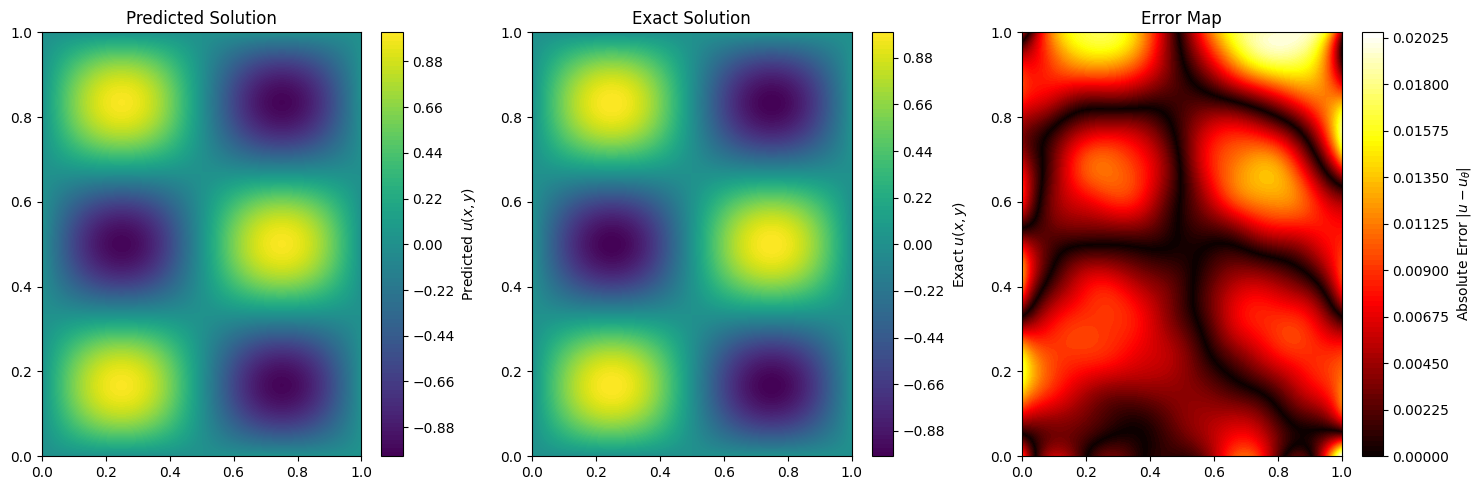

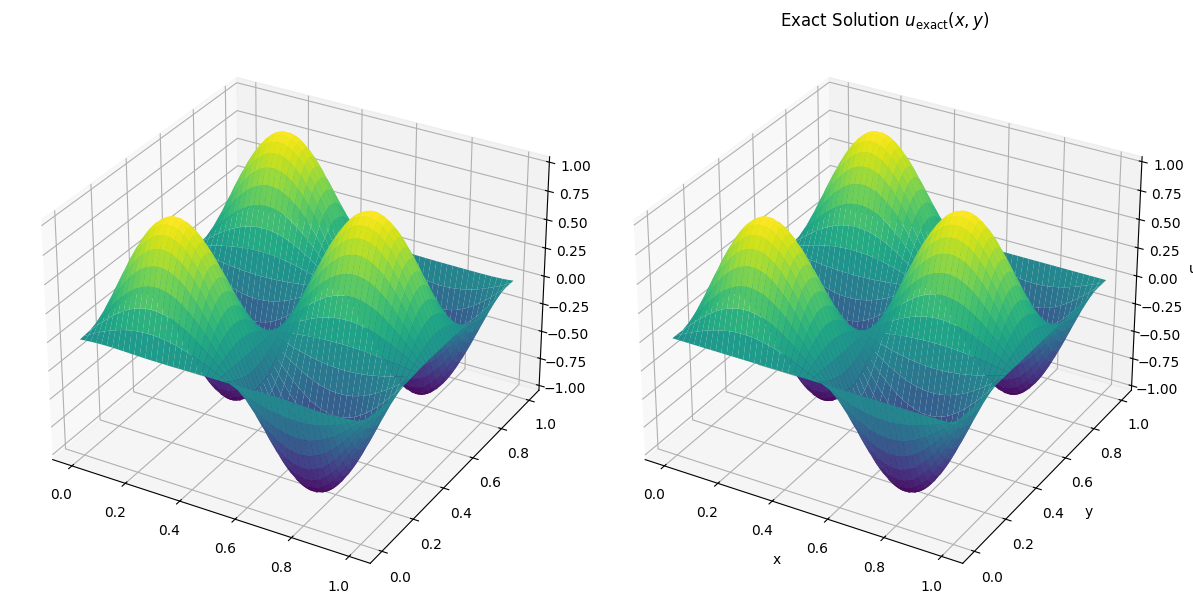

In [29]:
N = 1000 # Grid resolution
x_vals = np.linspace(0, 1, N)
y_vals = np.linspace(0, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)

# Convert these to Pytorch tensors
X_torch = torch.tensor(X.flatten(), dtype=torch.float32)
Y_torch = torch.tensor(Y.flatten(), dtype=torch.float32)

# Use trained model to predict u(x, y)
with torch.no_grad():
    U_pred = model_0(X_torch, Y_torch).numpy()

# Reshape predictions back to a 2D grid
U_pred = U_pred.reshape(N, N)

# Put the true function here again this time using numpy operations
# Can't be bothered to dither with these pytorch detach() and to_numpy operations
u_exact = lambda x, y: np.sin(2*np.pi*x) * np.sin(3*np.pi*y)
U_exact = u_exact(X, Y)

abs_error = np.abs(U_pred - U_exact)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.contourf(X, Y, U_pred, levels=100, cmap="viridis")
plt.colorbar(label="Predicted $u(x,y)$")
plt.title("Predicted Solution")

plt.subplot(1, 3, 2)
plt.contourf(X, Y, U_exact, levels=100, cmap="viridis")
plt.colorbar(label="Exact $u(x,y)$")
plt.title("Exact Solution")

plt.subplot(1, 3, 3)
plt.contourf(X, Y, abs_error, levels=100, cmap="hot")
plt.colorbar(label="Absolute Error $|u - u_{\\theta}|$")
plt.title("Error Map")

plt.tight_layout()

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, U_pred, cmap="viridis", edgecolor='none')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, U_exact, cmap="viridis", edgecolor='none')
ax2.set_title("Exact Solution $u_{\mathrm{exact}}(x,y)$")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u")

# Show the plots
plt.tight_layout()
plt.show()

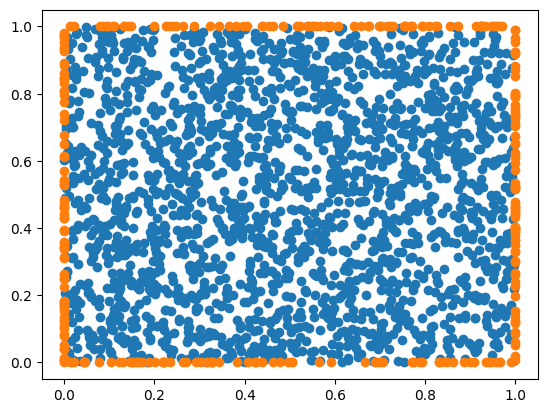

In [12]:
# Let's visualise where thr training data was

x_in_np = x_in.detach().numpy()
y_in_np = y_in.detach().numpy()

xb_np = xb.detach().numpy()
yb_np = yb.detach().numpy()

plt.scatter(x_in_np, y_in_np)
plt.scatter(xb_np, yb_np)
plt.title("Training data distrbution")
plt.xlabel()
plt.show()

In [21]:
# Finally, let's train properly properly

N_interior = 2000
x_in = torch.rand(N_interior)
y_in = torch.rand(N_interior)
f_in = f_fn(x_in, y_in)

N_boundary = 300
xb_left, yb_left = torch.zeros(N_boundary//4), torch.rand(N_boundary//4)
xb_right, yb_right = torch.ones(N_boundary//4), torch.rand(N_boundary//4)
xb_bottom, yb_bottom = torch.rand(N_boundary//4), torch.zeros(N_boundary//4)
xb_top, yb_top = torch.rand(N_boundary//4), torch.ones(N_boundary//4)

xb = torch.cat([xb_left, xb_right, xb_bottom, xb_top])
yb = torch.cat([yb_left, yb_right, yb_bottom, yb_top])

# Split data 80:20
x_train, x_val, y_train, y_val, f_train, f_val = train_test_split(x_in.numpy(), y_in.numpy(), f_in.numpy(), test_size=0.2, random_state=42)
xb_train, xb_val, yb_train, yb_val = train_test_split(xb.numpy(), yb.numpy(), test_size=0.2, random_state=42)

x_train_torch, y_train_torch, f_train_torch = map(torch.tensor, (x_train, y_train, f_train))
x_val_torch, y_val_torch, f_val_torch = map(torch.tensor, (x_val, y_val, f_val))
xb_train_torch, yb_train_torch = map(torch.tensor, (xb_train, yb_train))
xb_val_torch, yb_val_torch = map(torch.tensor, (xb_val, yb_val))

model_1 = PDE_nn()
optimiser = torch.optim.Adam(model_1.parameters(), lr)

max_epochs = 5000
train_losses, val_losses = [], []
for epoch in range(max_epochs):

    optimiser.zero_grad() # Clear gradients accumulated from previous iteration
    residual = compute_pde_residual(model_1, x_train_torch, y_train_torch, f_fn)
    boundary_loss = boundary_error(model_0, xb_train_torch, yb_train_torch)

    total_error = residual + boundary_loss
    total_error.backward()
    optimiser.step()

    with torch.no_grad():
        residual_val = compute_pde_residual(model_1, x_val_torch, y_val_torch, f_fn)
        boundary_loss_val = boundary_error(model_1, xb_val_torch, yb_val_torch)
        total_error_val = residual_val + boundary_loss_val
    
    train_losses.append(total_error.item())
    val_losses.append(total_error_val.item())


    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {total_error.item():.6f}, Validation Loss = {total_error_val.item():.6f}")



plt.figure(figsize=(8, 5))
plt.plot(range(max_epochs), train_losses, label="Training Loss", color='blue')
plt.plot(range(max_epochs), val_losses, label="Validation Loss", color='red', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [30]:
np.sqrt(3000)

np.float64(54.772255750516614)

In report, have a section that covers how the neural network architecture was obtained. Gridsearch for different parameters, that kind of thing.

Consider scenarios of NN PDEs that kind of thing